# Regresión I: ¿Donde estan los ojos?
Autores: German Sarmiento, Camila Lozano

### Introducción

Muchos de los sistemas de reconocimiento de personas por medio de imágenes utilizan la ubicación de puntos importantes en la cara, con el objetivo de identificar la ubicación del rostro. Algunos puntos importantes son los ojos, la nariz y la boca, a partir de ellos es posible definir las coordenadas entre las cuales se encuentra ubicada la cara de la persona. La detección de estos puntos es escencial para los algoritmos de reconocimimiento facial.

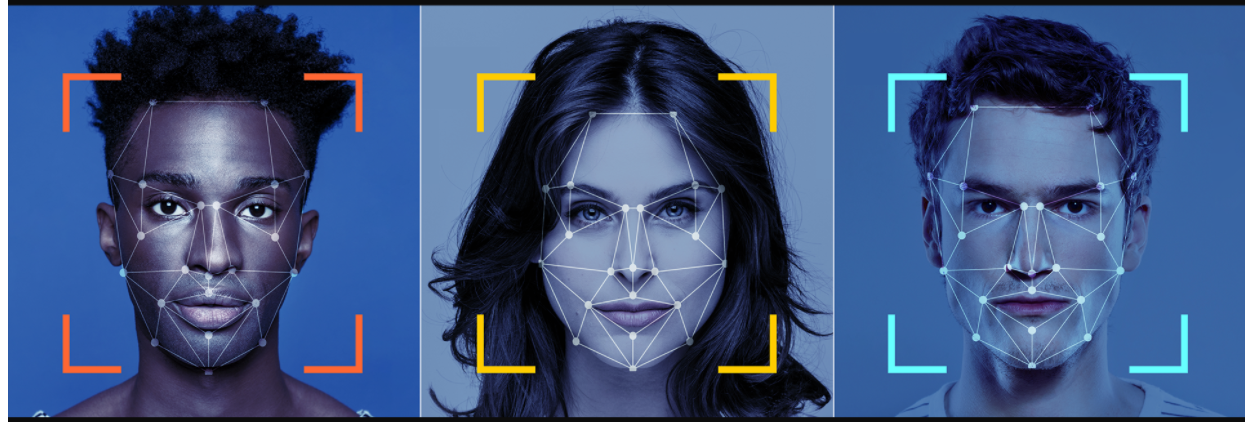

In [11]:
from IPython.display import Image
Image("FacialDetectionImage.png")

Identificación de puntos como los ojos resulta de suma importancia en campos como prevención de accidentalidad víal, dado que pueden ayudar a identificar fatiga o ojos caidos (Sudhakara, 2012).

El objetivo de este notebook es realizar un sistemas de identificación de la ubicación de los ojos a partir de imágenes.Para ello, implementamos un modelo de redes neuronales MLP para utilizando un conjunto de 1236 imagenes que fueron previamente etiquetdas por el proyecto "GI4E - Gaze Interaction for Everybody" de la Universidad Pública de Navarra, dispuesta en el siguiente link: https://www.unavarra.es/gi4e/databases/gi4e/. 

Esta base de datos contiene 1236 imagenes en formato png de 103 personas con una resolución de 800×600 pixeles, cada persona cuenta con 12 imagenes. Cada imagen viene acompañada de su etiqueta en los ojos, de tal manera que cada una de las imagenes tiene un archivo .txt asociado agrupado por persona, con la siguiente información: x1 y1 x2 y2 x3 y3 x4 y4 x5 y5 x6 y6, en donde:

    * Los puntos (x1,y1) corresponden a las coordenadas de la parte externa de la cornea en el ojo izquierdo
    * Los puntos (x2,y2) corresponden a las coordenadas del centro del iris del ojo izquierdo 
    * Los puntos (x3,y3) corresponden a las coordenadas de la parte interna de la cornea en el ojo izquierdo
    * Los puntos (x4,y4) corresponden a las coordenadas de la parte externa de la cornea en el ojo derecho
    * Los puntos (x5,y5) corresponden a las coordenadas del centro del iris del ojo derecho 
    * Los puntos (x6,y6) corresponden a las coordenadas de la parte interna de la cornea en el ojo derecho

De esta manera el objetivo de este ejercicio es predicir los valores de x1 y1 x2 y2 x3 y3 x4 y4 x5 y5 x6 y6. Las imagenets contiene personas distintas, con gafas, sin gafas mirando en diferentes direcciones.


Estas imagenes fueron reescaladas y se utilizaron como entrenamiento de un modelo de redes neuronales Multy Layer Perceptron con el objeto de obtener las coordenadas de los ojos. Depués de entrenado el modelo, se evaluó su desempeño.


### Métodos

Durante los últimos años y dada la importancia de este tema, se han explorado diferentes aproximaciones metodológicas para detectar las coordenadas de los ojos. Algunos de estos métodos parte de capturar las propiedades fisiológicas de los ojos utilizando modelos de aspecto de los ojos para representar patrones de los ojos. En estos modelos el centro y el radio del iris se detectan buscando un círculo que separa el iris oscuro y la esclerotica brillante. No obstante, estos metodos requieren de una gran cantidad de imagenes de entrenamiento para identificar dichas porpiedades fisiológicas del ojo. Otros métodos útilizados incluyen análisis de componentes principales, lógica difusa, modelos de Markov, entre otros. No obstante, las redes neuronales han emostrado ser eficientes en la detección de objetos faciales (Sudhakara, 2012). 

Por tanto, para solucionar este problema de reconocimiento de patrones visuales implementamos una red neuronal Multi Layer Perceptron. El problema que se busca resolver es un problema de regresión, en el cuál el valor a predecir son las coordenadas de los puntos en los cuales se encuntran los ojos de las personas. Para ello se utilizaron las 1236 imagenes para entrenar el modelo las cuales fueron reescaladas y posteriormente se realizó la evaluación del modelo.

La red neuronal de tipo multilayer perceptron fue entrenada ccon sólo una capa oculta. La cantidad de características corresponde al número de pixeles totales de la imagen a color. La red recibió 50 * 50 * 3 valores y generó como insumo un vector con 4 puntos indicando las coordenadas x, y del centro del iris del ojo izquierdo  y del centro del iris del ojo derecho. Por otra parte, con el objeto de generalizar se utiliza una capa `Dropout`, la cual vuelve cero el 15% de las activaciones de neuronas de la capa anterior. La función de costo se define con mínimos cuadrados ordinarios.




### Solución

Iniciaremos importanto las librerias. Para este ejercicio utilizaremos torch y torchvison 

In [3]:
#Imports

import numpy as np
from torch import nn, optim
import torch
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

import os
import glob
from torchvision.io import read_image

import matplotlib.pyplot as plt
%matplotlib inline

Lo primero que hacemos es descargar e importar al proyecto el conjunto de las 1236 imagenes en formato .png

In [4]:
train_dir = "DataIMG/images/"

images = glob.glob(os.path.join(train_dir,'*.png'))



Cada persona tiene asociado un archivo .txt, que agrupa, de las 12 muestras por persona, los puntos  x1 y1 x2 y2 x3 y3 x4 y4 x5 y5 x6 y6 que deseamos estimar. Por tanto, a cada imagen le asociamos sus coordenadas que indican la posición de los ojos.  
  
  

In [5]:
print(images[0])
anot0_file = "DataIMG/labels/" + images[0][15:19] + 'image_labels.txt'
print(anot0_file)


DataIMG/images\001_01.png
DataIMG/labels/001_image_labels.txt


Los 12 puntos contenidos en el archivo "001_image_labels.txt" corresponden a x1 y1 x2 y2 x3 y3 x4 y4 x5 y5 x6 y6, respectivamente

In [6]:
anot0 = np.genfromtxt(anot0_file)
anot0 = np.array(anot0[0:1,1:]).reshape(12)
print(anot0.shape)
print(anot0)

(12,)
[490.63 338.28 471.22 338.41 452.86 341.93 401.95 342.45 383.33 339.84
 362.63 338.41]


Verificamos que la resolución de una de las imagenes sea de 800×600 pixeles, y cada pixel contiene su información de colores representada por su RGB.

In [7]:
person = read_image(images[0])
person.shape

torch.Size([3, 600, 800])

Pintamos una imganen con los 12 puntos de entrenamiento (x1 y1 x2 y2 x3 y3 x4 y4 x5 y5 x6 y6) asociados a esa imagen. Los puntos ubicados en la cornea se pintan de color rojo y el centro deliris en color amarillo

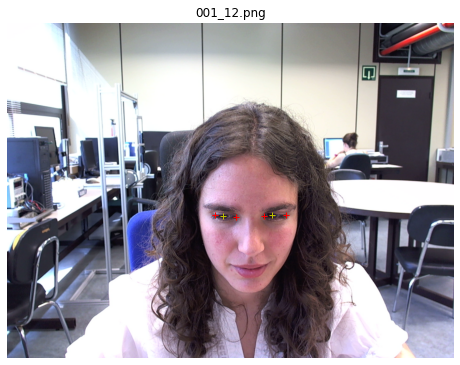

In [8]:
from IPython.display import clear_output
from time import sleep

for i in range(12):
    clear_output(wait=True)
    
    person = read_image(images[i])
    
    anot0_file = "DataIMG/labels/" + images[i][15:19] + 'image_labels.txt'
    anot0 = np.genfromtxt(anot0_file)
    anot0 = np.array(anot0[i:i + 1,1:]).reshape(12)
    
    plt.figure(figsize=(8,8))
    plt.imshow(person.permute(1,2,0))
    plt.plot(anot0[0],anot0[1],'+r')
    plt.plot(anot0[2],anot0[3],'+y') #Pupila izquierda
    plt.plot(anot0[4],anot0[5],'+r')
    plt.plot(anot0[6],anot0[7],'+r')
    plt.plot(anot0[8],anot0[9],'+y') #Pupila derecha
    plt.plot(anot0[10],anot0[11],'+r')
    plt.axis('off')
    plt.title(images[i][15:])
    plt.show()
    sleep(0.3)

Reescalamos todas las imagenes de 800×600 pixeles a 50*50 pixeles. Y reescalamos así mismo los puntos de ubicación de los ojos.

Text(0.5, 1.0, '001_01.png')

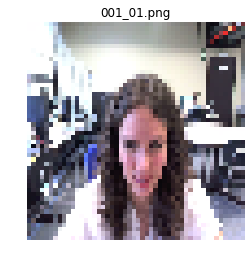

In [53]:
person = read_image(images[0])

anot0_file = "DataIMG/labels/" + images[0][15:19] + 'image_labels.txt'
anot0 = np.genfromtxt(anot0_file)
anot0 = np.array(anot0[0:1,1:]).reshape(12)

resize = transforms.Resize(size=(50,50))

plt.imshow(resize(person).permute(1,2,0))
plt.axis('off')
plt.title(images[0][15:])


In [9]:
print(person.shape)

torch.Size([3, 600, 800])


Re escalamiento de los puntos de los ojos.  
 
 ---

In [35]:
print(person.shape[1])
print(person.shape[2])

600
800


In [10]:
dy, dx = person.shape[1]/50, person.shape[2]/50
print(dy, dx)

12.0 16.0


In [11]:
print(anot0)
for i in range(12):
    if i == 0 or i % 2 ==0:
        anot0[i] = np.round(anot0[i]/dx)
    else:
        anot0[i] = np.round(anot0[i]/dy)
print(anot0)

[490.63 338.28 471.22 338.41 452.86 341.93 401.95 342.45 383.33 339.84
 362.63 338.41]
[31. 28. 29. 28. 28. 28. 25. 29. 24. 28. 23. 28.]


Imagen re escalada a 50x50 con sus respectivos puntos de los ojos.

Text(0.5, 1.0, '001_01.png')

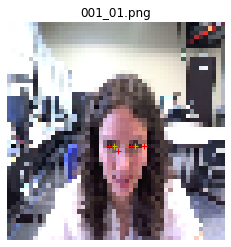

In [12]:
plt.imshow(resize(person).permute(1,2,0))


plt.plot(anot0[0],anot0[1],'+r')
plt.plot(anot0[2],anot0[3],'+y') #Pupila izquierda
plt.plot(anot0[4],anot0[5],'+r')
plt.plot(anot0[6],anot0[7],'+r')
plt.plot(anot0[8],anot0[9],'+y') #Pupila derecha
plt.plot(anot0[10],anot0[11],'+r')
plt.axis('off')
plt.title(images[0][15:])

La siguiente clase une todo el proceso desde la lectura de los archivos y el reescalamiento.  
  
  Para este caso, debido al tamaño de las imágenes y del conjunto de datos de prueba, solo se va a trabajar con los puntos principales del iris (coordenadas del centro del ojo).  
  
  Por lo cual la implementación solo trabaja con 4 puntos, un par x1,y1 para un ojo y un par x2, y2 para el otro ojo.

In [9]:
class CustomImageDataset(Dataset):
    def __init__(self,img_dir,resizes=None):
        self.img_dir = img_dir
        self.resizes = resizes #Tupla (altura, ancho) del tamaño resultante de re-escalar la imagen
        self.list_img = glob.glob(os.path.join(img_dir,'*.png')) # lista de los archivos de sólo la imágenes       
        
    def __len__(self):
        return len(self.list_img)
    
    def transform(self, image, y):
        # Re-escalamiento de las coordenadas del punto según el re-escalamiento de la imagen
        dy, dx = image.shape[1]/self.resizes[0], image.shape[2]/self.resizes[1]
        
        for i in range(4):
            if i == 0 or i % 2 ==0:
                y[i] = np.round(y[i]/dx)
            else:
                y[i] = np.round(y[i]/dy)
        
        
        resize = transforms.Resize(size=self.resizes) #instancia el re-rescalamiento
        image = resize(image) #ejecuta el re-escalamiento
        return image/255, torch.tensor(y).float() #para que tambien sea y un torch.tensor. y el image/255 es para normalizar el tensor entre 0 y 1 (y sea float)      
    
    def __getitem__(self,idx):
        image = read_image(self.list_img[idx]) # con read_image la imagen se lee ya como tensor
        
        anot_file = "DataIMG/labels/image_labels.txt" #Aquí esta el total de corrdenadas de todas las imagenes
        anot = np.genfromtxt(anot_file)
        anot = np.array(anot[idx :idx + 1,1:]).reshape(12)
        
        y = np.array([anot[2], anot[3], anot[8], anot[9]])# leyendo solo las coordenadas de pupila izquierda y derecha
        if self.resizes:
            image, y = self.transform(image, y) 
        return image, y

Se crea una función para graficar las imágenes con matplotlib y las coordenadas de los ojos. En la función graficaremos los centro del iris del ojo izquierdo  y del centro del iris del ojo derecho.

In [54]:
def plot_person(img,eyes,s=None):
    if s is not None:
        plt.figure(figsize=(s,s))
    plt.imshow(img.permute(1,2,0)) # paso necesario debido al formato de las imágenes en pytorch
    plt.plot(eyes[0],eyes[1],'+r')
    plt.plot(eyes[2],eyes[3],'+r')
    plt.axis('off')

Creando los datasets para entrenamiento y validación (y también los dataloaders)

In [13]:
##########################
### CONFIGURACION
##########################

RANDOM_SEED = 123
NUM_EPOCHS = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr = 0.01
RS = 50 # escalamiento de todas la imagenes a RS x RS
BS = 300

torch.manual_seed(RANDOM_SEED);

In [66]:
torch.cuda.is_available()

True

Instanciando el dataset de training.

In [57]:
train_ds = CustomImageDataset(train_dir, resizes=(RS,RS))

In [58]:
img,y = train_ds[34] # una persona específico

Probamos nuestra función de pintar.

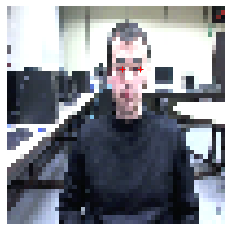

In [59]:
plot_person(img,y)

Iterando a través del DataLoader. Se construye el `DataLoader`a partir del conjunto de entrenamiento para un batch específico y revolviéndolos aleatoriamente

In [70]:
train_dl = DataLoader(train_ds, batch_size=BS, shuffle=True, )

In [71]:
img, y = next(iter(train_dl))
print(f"image batch size: {img.size()}")
print(f"mouth batch size: {y.size()}")

image batch size: torch.Size([300, 3, 50, 50])
mouth batch size: torch.Size([300, 4])


Vemos que en este caso, la primera imagen (posición 0), no concuerda con el orden de las imágenes en la librería de imágenes, de igual forma, cada vez que ejecutemos de nuevo las líneas anteriores, siempre obtendremos una imagen distinta en el índice 0.  
  
  Por otro lado, debido al re escalamiento, observamos como tiende a “deformarse” la ubicación de los iris.

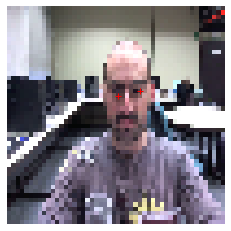

In [72]:
plot_person(img[0],y[0])

Construyendo el Dataset y DataLoader para el conjunto de validación

In [73]:
valid_ds = CustomImageDataset(train_dir, resizes=(RS,RS))
valid_dl = DataLoader(valid_ds, batch_size=BS*2)

Entrenando una red neuronal artificial de tipo multilayer perceptron (MLP) con sólo una capa oculta. La cantidad de características corresponde al número de pixeles totales de la imagen a color. La red recibirá 50 * 50 * 3 valores y generará como capa de salida un vector con 4 puntos indicando las coordenadas x, y del centro del iris del ojo izquierdo  y del centro del iris del ojo derecho.

Con el objeto de generalizar, se utiliza una capa `Dropout`, la cual vuelve cero el 15% de las activaciones de neuronas de la capa anterior. 


In [74]:
model = nn.Sequential(
    nn.Linear(RS*RS*3,200),
    nn.Dropout(p=0.15), 
    nn.ReLU(),
    nn.Linear(200, 4)
)

Definimos la función de costo con mínimos cuadrados ordinarios, `mse_loss`. Cuando existe múltiples variables respuesta, `mse_loss` calcula el *MSE* para cada variable de salida y luego los promedia

In [75]:
loss_func = F.mse_loss
model = model.to(DEVICE)
opt = optim.RMSprop(model.parameters(),lr = lr, momentum=0.9)

scheduler = optim.lr_scheduler.OneCycleLR(
    opt, max_lr=0.01, steps_per_epoch=len(train_dl), epochs=NUM_EPOCHS) #El scheduler es un control sobre los valores del LR que busca acelerar el aprendizaje, buscar el mejor modelo, evitar atascos en mínimos muy locales, etc. 

Se calcula el loss a un minibatch aplanando la imagen.

In [76]:
def loss_batch(xb,yb):
    yp = model(xb.view(-1, RS*RS*3).to(DEVICE)) # Se reforma la imagen a un vector columna
    yt = yb.to(DEVICE)
    loss = loss_func(yp, yt)
    out = [loss, len(xb)]
    return out

Y realizamos el típico método train .

In [77]:
def train():
    
    train_losses = []
    valid_losses = []
    for epoch in range(NUM_EPOCHS):
        model.train()
        losses = 0
        nums = 0
        for xb, yb in train_dl:
            loss, l = loss_batch(xb,yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
            losses += loss.item() * l
            nums += l
            scheduler.step()
        train_loss = losses / nums
        train_losses.append(train_loss)
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(*[loss_batch(xb, yb) for xb, yb in valid_dl])
        losses = [l.item() for l in losses]
        valid_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)
        valid_losses.append(valid_loss)
              
        if epoch % 5 == 0:
            print(f"epoch: {epoch},    train_loss: {train_loss:.4f} \
            valid_loss: {valid_loss:.4f}")
    
    plt.plot(range(NUM_EPOCHS), train_losses, 'r', label='train')
    plt.plot(range(NUM_EPOCHS), valid_losses, 'b', label = 'valid')
    plt.legend()

epoch: 0,    train_loss: 619.7824             valid_loss: 135.5384
epoch: 5,    train_loss: 48.3557             valid_loss: 30.9149
epoch: 10,    train_loss: 48.0570             valid_loss: 14.8825
epoch: 15,    train_loss: 31.8103             valid_loss: 9.8346
epoch: 20,    train_loss: 30.8837             valid_loss: 6.7675
epoch: 25,    train_loss: 27.3750             valid_loss: 12.8759
epoch: 30,    train_loss: 55.1955             valid_loss: 4.0020
epoch: 35,    train_loss: 31.3419             valid_loss: 4.8636
epoch: 40,    train_loss: 27.1570             valid_loss: 21.0954
epoch: 45,    train_loss: 118.0337             valid_loss: 23.6200
epoch: 50,    train_loss: 67.6150             valid_loss: 23.6997
epoch: 55,    train_loss: 66.5217             valid_loss: 18.8285
epoch: 60,    train_loss: 59.1077             valid_loss: 14.2980
epoch: 65,    train_loss: 54.2567             valid_loss: 12.5051
epoch: 70,    train_loss: 53.5974             valid_loss: 14.4810
epoch: 75,   

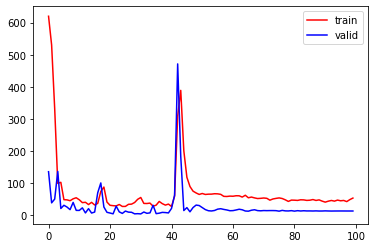

In [78]:
train()

El entrenamiento de la red, toma en promedio más de 3 horas con equipo de procesador i5, con una tarjeta gráfica NVIDIA GTX 1660, que por cierto desde Pytorch no fue posible forzar al uso de la tarjeta gráfica.

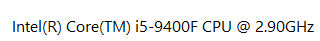
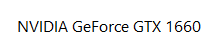

In [79]:
ypred = model(img.view(-1, RS*RS*3).to(DEVICE))
ypred

tensor([[24.8048, 20.3201, 20.4560, 20.3859],
        [25.8545, 21.1693, 21.4349, 21.2485],
        [28.4695, 23.2849, 23.8736, 23.3975],
        ...,
        [24.7495, 20.2754, 20.4045, 20.3405],
        [27.6009, 22.5822, 23.0636, 22.6837],
        [23.0241, 18.8795, 18.7955, 18.9226]], device='cuda:0',
       grad_fn=<AddmmBackward>)

Ahora comparamos los resultados de las coordenadas originales vs las coordenadas generadas a partir del modelo. 

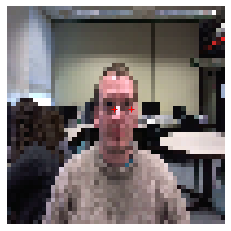

In [82]:
i = 5
plot_person(img[i],y[i])

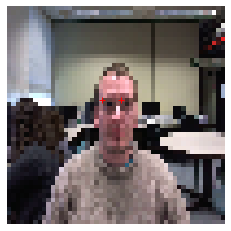

In [83]:
plot_person(img[i],ypred[i].detach().cpu().numpy())

Se puede apreciar que se acerca bastante, aunque por supuesto no da el mismo valor.

In [ ]:
resize = transforms.Resize(size=(50,50)) 

Exportando el modelo para inferencia (predicción)

In [84]:
torch.save(model.state_dict(), "model_MLP_eyes.pth")

### Implementación del modelo
Ahora realicemos la inferencia, construyendo el modelo, cargándole los pesos y llevándolo a la CPU (es mejor hacer inferencia sobre CPU).  
  
  Se construye  la función `where_eyes`, la cual, a partir del modelo creado, intenta predecir el posicionamiento de los ojos(iris), en la imagen. La función recibe como parámetro, la ruta donde se encuentra la imagen.

In [62]:
def where_eyes(im_path):
    modelp = nn.Sequential(
    nn.Linear(RS*RS*3,200),
    nn.Dropout(p=0.15), 
    nn.ReLU(),
    nn.Linear(200, 4)
    )
    modelp.load_state_dict( torch.load("model_MLP_eyes.pth", map_location=torch.device('cpu')))
    modelp.eval()
    
    im = read_image(im_path)
    im_r = transforms.Resize(size=(RS,RS))(im)/255 # re-escalamos y normalizamos (para convertir a float entre 0y1)

    with torch.no_grad():
        ypred = modelp(im_r.view(-1, RS*RS*3))
    
    plt.figure(figsize=(8,8))
    plt.imshow(im.permute(1,2,0))
    plt.axis('off')
    plt.show()
    
    #Las coordenadas estan dadas en una imagen de 50*50, por lo cual se debe reescalar las mismas
    dy, dx = 12, 16
        
    for i in range(4):
        if i == 0 or i % 2 ==0:
            ypred[0][i] = np.round(ypred[0][i]*dx)
        else:
            ypred[0][i] = np.round(ypred[0][i]*dy)

   
    plot_person(im,ypred[0], 8)
    

Leyendo una imagen del mismo dataset y haciendo la predicción:

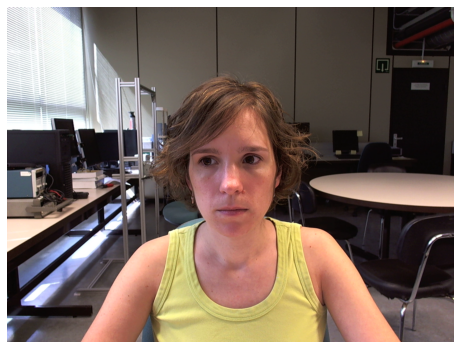

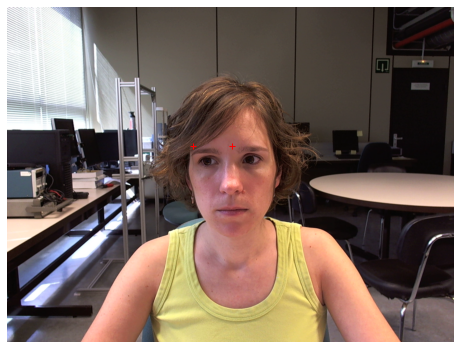

In [69]:
im_path = "DataIMG/images/002_05.png"
where_eyes(im_path)

Ahora, si seleccionamos otra imagen de rostro que no fue tenida en cuenta en el entrenamiento, vemos que aún trata de acercarse bastante a la zona de los ojos, sin embargo, debido a que en el entrenamiento la distancia de los ojos es más pequeña, la percepción del otro ojo, da muy cerca a la nariz, mantiene una relación de aspecto en cuanto a distancia con la media de distancias de entre ojos que hay en el conjunto de entrenamiento.

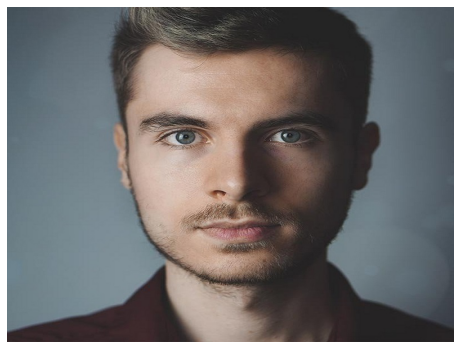

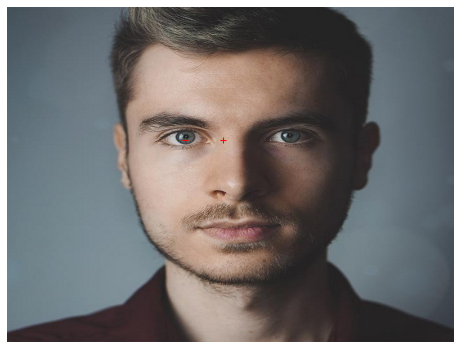

In [73]:
im_path = "img_test.jpg"
where_eyes(im_path)


Ahora, probamos con otra imagen, en la cual la persona, tiene un parche en uno de sus ojos. Podemos observar que en este caso el modelo no se acerca en lo absoluto y en parte, la explicación puede estar dada por la falta de muestras en el conjunto de entrenamiento donde existieran personas con solo ojo visible.


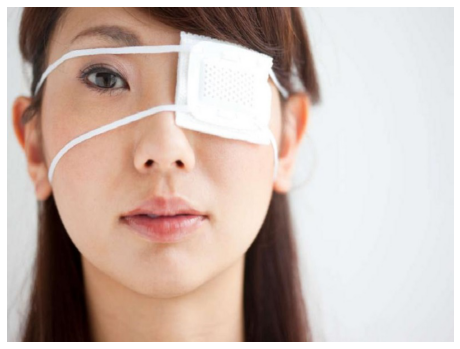

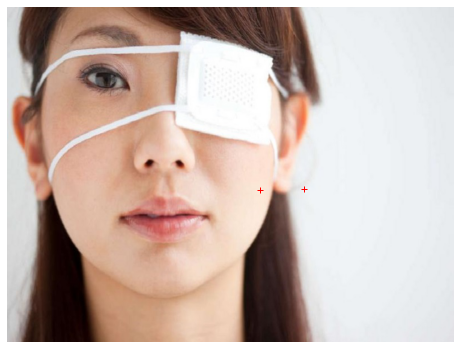

In [74]:
im_path = "img_test2.jpg"
where_eyes(im_path)

### Discusión

Hay una gran cantidad de caracteristicas humanas y variabilidades que pueden afectar el desarrollo del algoritmo como por ejemplo el uso de gafas de diferentes tipos, la dirección de la mirada, la iluminación de la foto, fondo de la foto, alineación de la cara, expresiones fáciales, rotación de los ojos, entre otros.

Dentro de los cambios que se podrían haber explroado para mejorar el desempeño del algorimo estan:  
  * Convertir las imagentes a escala de grises.  
  * Rotar las imagenes.  
  * Recortar las imagenes para obtener mayor precisión del área del ojo, haciendo Zoom a las mismas.  
  * Reducción de dimensionalidad.  

### Conclusiones

El modelo implementado en este notebook predice 4 puntos correspondientes a las coordenas del iris del ojo izquierdo y el ojo derecho de una persona. Para su construcción utilizó como insumo 1236 imagenes. Una vez evaluado el modelo se observa que si bien la red no predice el valor exacto de las coordenadas, predice un valor muy cercano a estas.

Quizá, incluyendo un mayor número de neuronas y capas ocultas, puede llegarse a obtener un modelo con una mayor precisión.  

Por otro lado, también podemos notar el pobre desempeño del modelo cuando se tienen situaciones de personas que solo tienen visible un ojo. Por supuesto, en los datos de entrenamiento no había ejemplos de personas que solo tuvieran un ojo expuesto.

### Bibliografía

Sudhakara Rao, P., & Sreehari, S. (2012). Neural Network Approach for Eye Detection. arXiv e-prints, arXiv-1205.

### Preguntas

1. ¿Qué puede concluir del comportamiento de la red y los datos proporcionados

Si bien la red no predice el valor exacto de las coordenadas, predice un valor muy cercano a estas.  

  El entrenamiento consume bastantes recursos de procesamiento y toma bastante tiempo, esto, a pesar de usar un redimensionamiento de las imágenes para trabajar con un número menor de Features.

2. ¿Qué criterio utilizo para seleccionar la arquitectura de la red?

La red neuronal de tipo multilayer perceptron fue entrenada con sólo una capa oculta. La cantidad de características corresponde al número de pixeles totales de la imagen a color. La red recibió 50 * 50 * 3 valores y generó como insumo un vector con 4 puntos indicando las coordenadas x, y del centro del iris del ojo izquierdo y del centro del iris del ojo derecho. La cantidad de neuronas en la capa oculta se seleccionó en función de la capacidad de cómputo.

La razón de no aumentar la complejidad de la red, se debe a los altos consumos registrados con una sola capa y 200 neuronas.

3. ¿Tiene la red el comportamiento esperado?, sino, ¿A qué cree que se debe esto?

Sí, la red predice los 4 puntos correspondientes a las coordendas del iris del ojo derecho y del ojo izquierdo.  

Aunque no cuenta con un alto grado de precisión en la predicción, tiene un acercamiento considerable en el área de los ojos. El inconveniente se presenta en el momento de predecir con imágenes de rostros que no están incluidos en el data set de entrenamiento y que poseen características diferenciales respecto a las imágenes usadas para entrenar el modelo, como por ejemplo, el uso de imágenes con un acercamiento mayor en el área facial, donde pudimos observar que si bien se acerca bastante al área de los ojos, la distancia entre los ojos no se predice de manera esperada, ya que la mayoría de los datos de prueba (imágenes) tenían una poca distancia entre los ojos, lo cual afecta la eficacia del modelo con imágenes que tienen otras características de tamaño diferente.  

4. ¿Qué le mejoraría al modelo que usted diseño?, ¿Cómo implementaría esas mejoras?

Dentro de los cambios que se podrían haber explroado para mejorar el desempeño del algorimo estan:  
   * Convertir las imagentes a escala de grises  
   * Rotar las imagenes  
   * Recortar las imagenes para obtener mayor precisión del área del ojo  
   * Reducción de dimensionalidad  